# Deep Learning for Computer Vision:  HW 2


## Computer Science: COMS W 4995 004


## Due: October 13, 2020

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu. For the loss function use a softplus on a linear output layer as we did in class.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects the solution.

e) Try choosing your own loss function (without asking me or the TAs what you should choose), repeating (d).

f) Now try with three inputs, generating your own training and validation data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisy as before.) Use softplus loss. Do not try to show the decision regions, instead generate a validation set in the same manner as the training set, classify the samples, and compute the classification accuracy.

g) Using your data from HW1 or any new data you curate, train your MLP using your training set (80%). Compute the error rate on your validation set (20%). It's up to you how many hidden units to use. 

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 65%, e=10%, f=5%, g=20%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [2]:
# Give 0 or 1 label using XOR operation for either two or three features input
def label_XOR(x_arr):
    if len(x_arr) == 2:
        return 1.0 * np.logical_xor(x_arr[0] == 1.0, x_arr[1] == 1.0)
    
    elif len(x_arr) == 3:
        if x_arr[0] == 0.0:
            return 1.0 * np.logical_xor(x_arr[1] == 1.0, x_arr[2] == 1.0)
        
        elif x_arr[1] == 0.0:
            return 1.0 * np.logical_xor(x_arr[0] == 1.0, x_arr[2] == 1.0)
        
        elif x_arr[2] == 0.0:
            return 1.0 * np.logical_xor(x_arr[0] == 1.0, x_arr[1] == 1.0)
        
    return 0.0

# Add random normal noise
def add_noise(x, coeff):
    return x + coeff * np.random.normal()

# Build an XOR dataset, with arbitrary number of data and features
def build_data(n_data, n_features):
    columns = []
    
    for i in range(0, n_features):
        columns.append('x' + str(i+1))
        
    columns.append('y')
    
    data = pd.DataFrame(np.zeros((n_data, n_features + 1)), columns=columns)
    
    x_arr = np.zeros(n_features)

    # Let's make up some noisy XOR data to use to build our binary classifier
    for i in range(len(data.index)):
        for j in range(0, n_features):
            x_arr[j] = 1.0 * random.randint(0,1)

        y = label_XOR(x_arr)

        for j in range(0, n_features):
            x_arr[j] = add_noise(x_arr[j], 0.15)

            data.iloc[i, j] = x_arr[j]
        
        data.iloc[i, n_features] = y

    return data

Build data and peak the content

In [3]:
data = build_data(5000, 2)

data.head()

,x1,x2,y
0,-0.096953,-0.009572,0.0
1,1.001510,0.181394,1.0
2,-0.058786,-0.354447,0.0
3,-0.130830,0.892687,1.0
4,0.909805,-0.276221,1.0


Let's message this data into a numpy format.

In [4]:
# Convert from DataFrame to Numpy and do sanity check
def convert_to_numpy(data):
    # set X (training data) and y (target variable)
    cols = data.shape[1]
    X = data.iloc[:, 0:cols-1]
    y = data.iloc[:, cols-1:cols]

    # The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
    X = np.matrix(X.values)
    y = np.matrix(y.values)
    
    return X, y

Split into X and y and do sanity check

In [5]:
X, y = convert_to_numpy(data)

assert X.shape == (5000, 2)
print(X[0:5])

assert y.shape == (5000, 1)
print(y[0:5])

[[-0.09695348 -0.00957185]
 [ 1.00151019  0.18139365]
 [-0.05878554 -0.35444696]
 [-0.13082988  0.89268652]
 [ 0.90980493 -0.27622134]]
[[0.]
 [1.]
 [0.]
 [1.]
 [1.]]


Let's make a sloppy plotting function for our binary data.

In [6]:
# Sloppy function for plotting our data
def plot_data(X, y_prob, title, cx, cy):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0, 1], color=cx, marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1, 1], color=cy, marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(title)
    plt.show()

Now let's plot it.

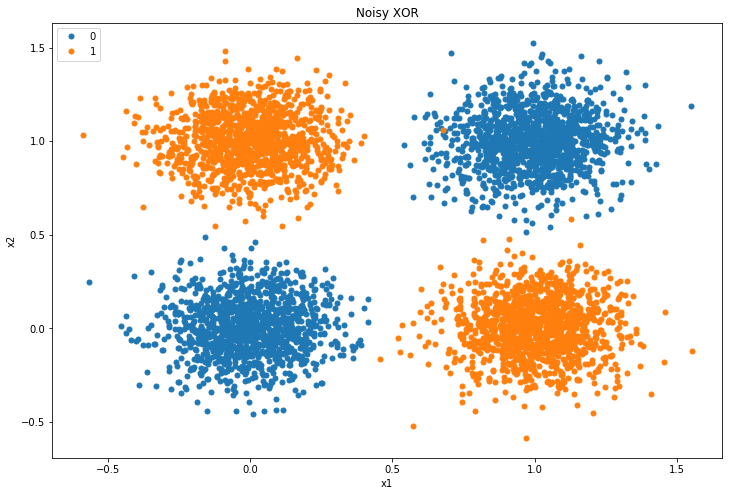

In [7]:
plot_data(X, y, 'Noisy XOR', None, None)

Now let's create functions for forward and backward prop through the layers and we are off...

### a) Implement each layer of the network as a separate function with both forward propagation and backpropagation.

Define needed functions

In [8]:
# Initialize network weights by using standard normal distribution 
def init_weights(n_features, n_hiddens):
    return {
        'w_hidden': np.random.randn(n_features, n_hiddens),
        'w_output': np.random.randn(n_hiddens, n_classes)
    }

# ReLU activation function for hidden layer
def apply_activation(input_vec, activation_type):
    if activation_type == 'linear':
        pass
    elif activation_type == 'relu':
        input_vec[input_vec < 0] = 0
    
    return input_vec

# Softplus loss for output layer
def apply_loss(input_vec, loss_type):
    if loss_type == 'softmax':
        exps = np.exp(input_vec - np.max(input_vec))
        
        return exps / np.sum(exps)
    elif loss_type == 'softplus':
        return np.power(1 + np.exp(-1.0 * input_vec), -1.0)
    
    return input_vec

# def cross_entropy(X,y):
#     """
#     X is the output from fully connected layer (num_examples x num_classes)
#     y is labels (num_examples x 1)
#     	Note that y is not one-hot encoded vector. 
#     	It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
#     """
#     m = y.shape[0]
#     p = softmax(X)
#     # We use multidimensional array indexing to extract 
#     # softmax probability of the correct label for each sample.
#     # Refer to https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays for understanding multidimensional array indexing.
#     log_likelihood = -np.log(p[range(m),y])
#     loss = np.sum(log_likelihood) / m
#     return loss

# Forward propagation for hidden layer
def forward_hidden(network, input_vec):
    # Supply input_vec to hidden layer
    hidden_value = input_vec @ network['w_hidden']
    
    # Apply ReLU activation
    hidden_activation = apply_activation(hidden_value, 'relu')
    
    return hidden_activation

# Forward propagation for output layer
def forward_output(network, hidden_vec, loss_type):
    # Supply hidden_vec to hidden layer
    output_value = hidden_vec @ network['w_output']
    
    # Apply Softplus/Softmax loss
    output_activation = apply_loss(output_value, loss_type)
    
    return output_activation    

# Backward propagation for both output and hidden layer
def backward(network, input_vecs, hidden_vecs, errors):
    # Errors are the gradients of the output layer, per minibatch
    dw_output = hidden_vecs.T @ errors

    # dh are the gradients of the hidden layer
    dh = errors @ network['w_output'].T
    
    dh[hidden_vecs <= 0] = 0
    
    dw_hidden = input_vecs.T @ dh

    # Return the gradients as dict
    return {
        'w_hidden': dw_hidden,
        'w_output': dw_output
    }

Make X, y as arrays and do sanity check

In [9]:
X = np.array(X)
y = np.array(y).flatten()

assert X.shape == (5000, 2)
assert y.shape == (5000,)

### b) Train the network using stochastic gradient descent with mini-batches.

Define needed functions

In [10]:
# For each iteration, shuffle the data before feeding it to the network
# so we don't get the same minibatches for every iteration
def shuffle(X, y):
    idxes = np.arange(X.shape[0])
    new_idxes = np.random.shuffle(idxes)
    
    return X[new_idxes][0], y[new_idxes][0]

# For each minibatch, do forward & backward propagation and compute the gradients
def get_minibatch_grad(network, X, y, loss_type):
    # Save the information in the structure below
    input_vecs, hidden_vecs, errors = [], [], []

    for x, cls_idx in zip(X, y):
        # Forward propagate
        h = forward_hidden(network, x)
        y_pred = forward_output(network, h, loss_type)

        # Create probability distribution of true label
        y_true = np.zeros(n_classes)
        y_true[int(cls_idx)] = float(1.0)

        # Compute the error between the activation and the label
        err = y_true - y_pred
        
        # Add all the info
        input_vecs.append(x)
        hidden_vecs.append(h)
        errors.append(err)

    # Backprop using the saved info
    return backward(network, np.array(input_vecs), np.array(hidden_vecs), np.array(errors))

# One step of SGD, i.e. computing gradient and updating weights for one minibatch
def do_sgd_step(network, X, y, learning_rate, loss_type):
    # Fetch minibatch grad
    grad = get_minibatch_grad(network, X, y, loss_type)
    network = network.copy()

    # Update every params, w_hidden and w_output, using the grad
    for layer in grad:
        network[layer] = network[layer] + learning_rate * grad[layer]

    return network

# Learning iterations
def do_sgd(network, X, y, minibatch_size, learning_rate, n_iters, loss_type, debug):
    for iter in range(n_iters):
        if debug:
            if (iter + 1) % 10 == 0:
                print('Iteration {}'.format(iter))

        # Shuffle 
        X, y = shuffle(X, y)

        # Iterate over minibatches
        for i in range(0, X.shape[0], minibatch_size):
            X_minibatch = X[i:i + minibatch_size]
            y_minibatch = y[i:i + minibatch_size]

            # Computes gradient and updates weights for one minibatch
            network = do_sgd_step(network, X_minibatch, y_minibatch, learning_rate, loss_type)

    return network

# Main learning routint
def train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, debug):
    # Initialize network
    network = init_weights(n_features, n_hiddens)
    
    # Do SGD for n_iterations
    network = do_sgd(network, X, y, minibatch_size, learning_rate, n_iters, loss_type, debug)
    
    return network

Train with hidden units of 10, see if it gives a good decision boundary later

In [11]:
n_features = 2 # (x1, x2)
n_classes = 2 # 0 or 1

n_hiddens = 10 # number of hidden units
n_iters = 100 # number of learning iteration

loss_type = 'softplus'
learning_rate = 1e-4
minibatch_size = 32

network = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

### c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels.

Define needed functions

In [12]:
# Predict label y given X
def classify(network, X, loss_type):
    # Probabilities placeholder
    probs = []
    
    # Iterate for each sample 
    for _, x in enumerate(X):
        # Forward propagate to get probability distribution of label y given X
        hidden_activation = forward_hidden(network, x)
        prob = forward_output(network, hidden_activation, loss_type)
        
        probs.append(prob)
        
    # Replace NaN with 1, it is usually when the denominator is zero
    probs = np.where(probs == np.NaN, 1, probs) 
    
    # Get label by taking the argmax of the prob dist
    return np.argmax(probs, axis=2)

# Generate 2D dense data for decision boundary
# The dense samples are square in shape, so x1_low == x2_low and x1_high == x2_high
def generate_dense_data_2d(network, low, high, step, loss_type):
    # How many dots are within one line, either vertically and horizontally
    reps = int((high - low) / step) + 1
    
    # Generate different x1s using np.arange
    x1 = np.arange(low, high + step, step)
    # Repeat, so we get something like: [-0.5, -0.5, -0.5, -0.4, -0.4, -0.4, ...]
    x1 = np.repeat(x1, reps)
    
    # Generate different x2s using np.arange, but the value is actually the same as x1s
    x2 = np.arange(low, high + step, step)
    # Make a tile, so we get something like: [-0.5, -0.4, -0.3, -0.5, -0.4, -0.3, ...]
    x2 = np.tile(x2, reps)
    
    # Set a placeholder of size reps squared
    n_data = reps ** 2
    dense_data = pd.DataFrame(np.zeros((n_data, 3)), columns=['x1', 'x2', 'y'])

    # Assign x1s and x2s to the placeholder, each as separate series
    dense_data.iloc[:, 0] = x1
    dense_data.iloc[:, 1] = x2
   
    # Create np.matrix of X feature to be feed to the network
    X = np.matrix(dense_data.iloc[:, 0:2].values)

    # Get probability distribution of label y given X
    y = classify(network, X, loss_type)
    
    # Assign ys to the placeholder
    dense_data.iloc[:, 2] = y
    
    return dense_data

# Convert from DataFrame to Numpy and do sanity check
def convert_and_check_data(data, n_data, dim):
    X, y = convert_to_numpy(data)

    y_modified = y.flatten()
    y_modified = np.array(y_modified)[0]

    assert X.shape == (n_data, dim)
    assert y_modified.shape == (n_data,)
    
    return X, y_modified

# Modify plot data to enable plotting overlay
def plot_data_overlay(X, y_prob, X_dense, y_prob_dense, title, colorset):
    cx, cy, cx_dense, cy_dense = colorset[0], colorset[1], colorset[2], colorset[3]
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    y_predict_dense = y_prob_dense > 0.5
    indices_0_dense = [k for k in range(0, X_dense.shape[0]) if not y_predict_dense[k]]
    indices_1_dense = [k for k in range(0, X_dense.shape[0]) if y_predict_dense[k]]
    
    ax.plot(X_dense[indices_0_dense, 0], X_dense[indices_0_dense, 1], color=cx_dense, marker='o', linestyle='', ms=5)
    ax.plot(X_dense[indices_1_dense, 0], X_dense[indices_1_dense, 1], color=cy_dense, marker='o', linestyle='', ms=5)
    
    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]
    
    ax.plot(X[indices_0, 0], X[indices_0, 1], color=cx, marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1, 1], color=cy, marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    
    ax.set_title(title)
    plt.show()

Generate densely sampled data from the trained network

In [13]:
dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Finally, plot the decision boundaries against XOR data with two features. The black regions are for $y=0$, meanwhile the pink regions, are for $y=1$.

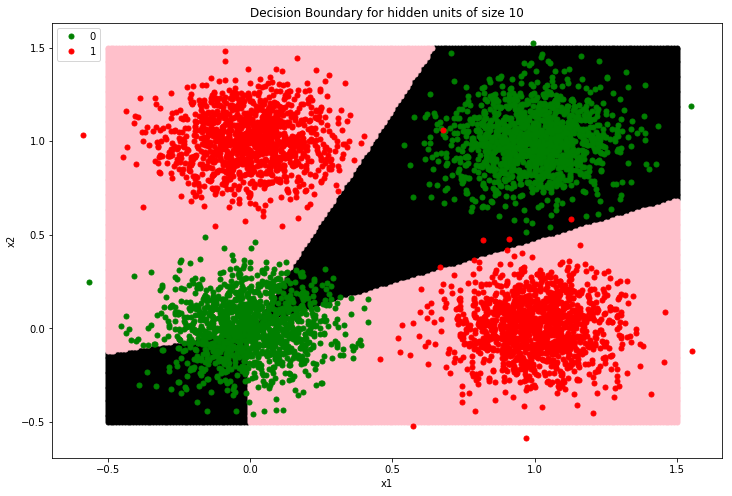

In [14]:
colorset = ['green', 'red', 'black', 'pink']

plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for hidden units of size 10', colorset)

### d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects the solution.

Generate densely sampled data from the trained network with hidden units of size 3

In [15]:
n_hiddens = 3

network = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Plot the decision boundaries against XOR data with two features

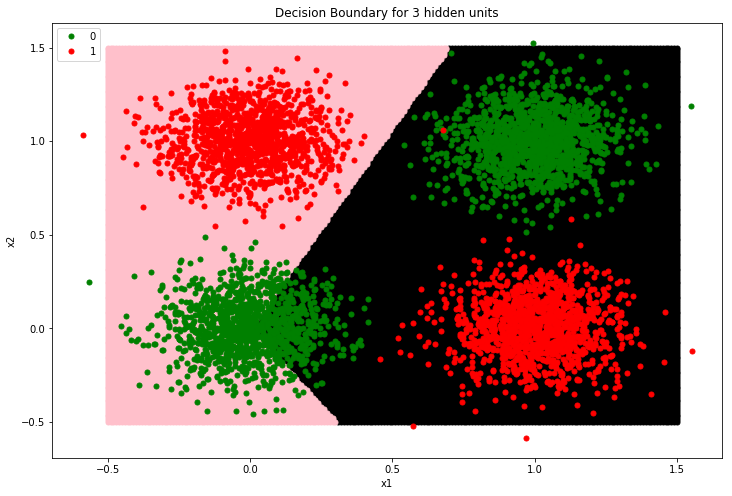

In [16]:
plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for 3 hidden units', colorset)

We could see that 3 hidden units are not sufficient. It can only separate well between the green dots ($y=0$) on the top right corner and the red dots ($y=1$) on the bottom right corner. 

The other red dots instances on the top left corner are fully misclassified, meanwhile the other green dots instances on the bottom left corner are roughly half misclassified.

Generate densely sampled data from the trained network with hidden units of size 16

In [17]:
n_hiddens = 16

network = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Plot the decision boundaries against XOR data with two features

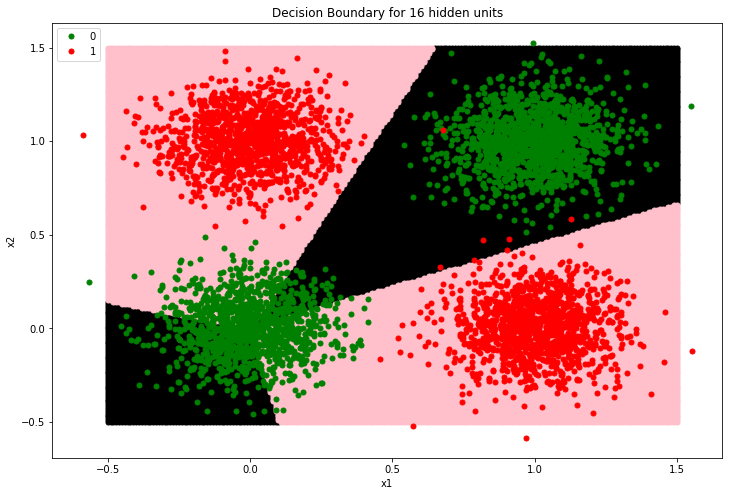

In [18]:
plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for 16 hidden units', colorset)

We could see that 16 hidden units, while not perfect, are quite sufficient. The pink regions include almost all red dots instances. The red dots outside the pink regions are possibly outliers, created by the noise.

The black regions include all green dots on the top right corner. But, it can't include all the green dots instances on the bottom left corner, just like the previous network with hidden units of size 3. Roughly 50-60% of those green dots are misclassified.

Generate densely sampled data from the trained network with hidden units of size 512

In [19]:
n_hiddens = 512

network = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Plot the decision boundaries against XOR data with two features

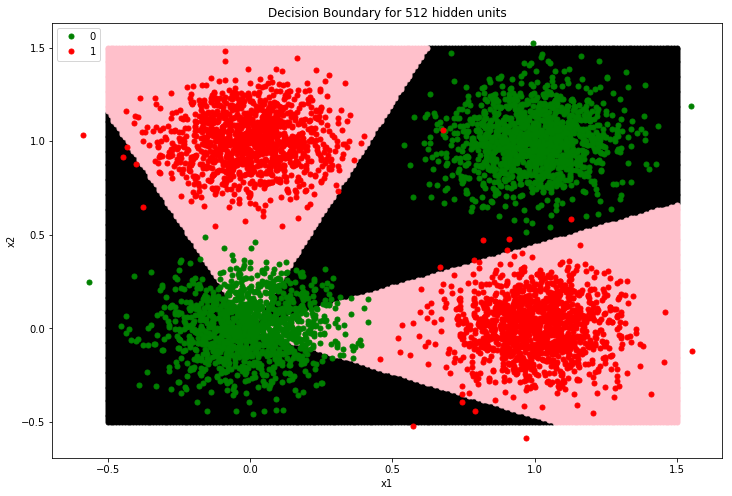

In [20]:
plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for 512 hidden units', colorset)

We could see that 512 hidden units are still not perfect. Just like the previous network with hidden units of size 16, the pink regions include almost all red dots instances. 

The black regions include all green dots on the top right corner, just like the previous network. However, the proportion of the green dots instances on the bottom left corner that are misclassified decrease significantly. From roughly 50-60% in the previous network, it decreases to around 20-30%.

### e) Try choosing your own loss function (without asking me or the TAs what you should choose), repeating (d).

I choose ```softmax``` loss.

Generate densely sampled data from the trained network with hidden units of size 3

In [21]:
n_features = 2 # (x1, x2)
n_classes = 2 # 0 or 1

n_hiddens = 3 # number of hidden units
n_iters = 100 # number of learning iteration

loss_type = 'softmax'
learning_rate = 1e-4
minibatch_size = 32

network = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Plot the decision boundaries against XOR data with two features

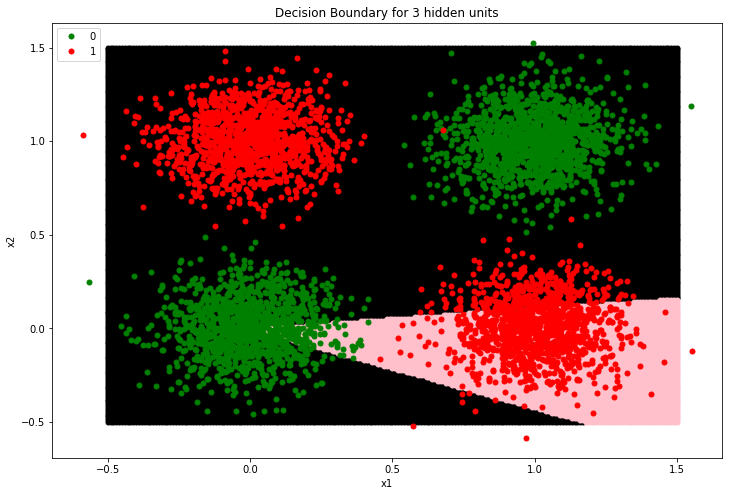

In [22]:
plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for 3 hidden units', colorset)

Generate densely sampled data from the trained network with hidden units of size 16

In [23]:
n_hiddens = 16

network = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Plot the decision boundaries against XOR data with two features

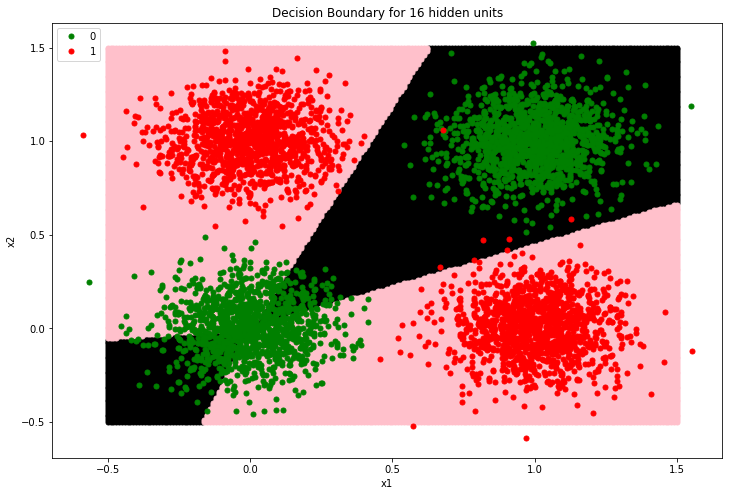

In [24]:
plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for 16 hidden units', colorset)

Generate densely sampled data from the trained network with hidden units of size 512

In [25]:
n_hiddens = 512

network = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Plot the decision boundaries against XOR data with two features

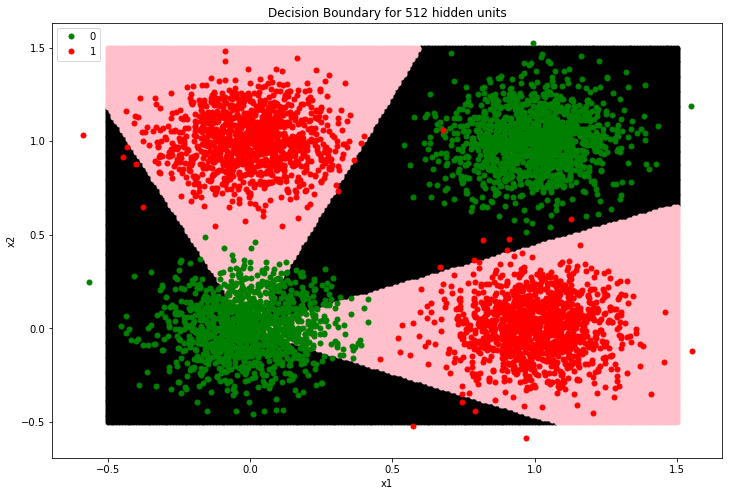

In [26]:
plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for 512 hidden units', colorset)

### f) Now try with three inputs, generating your own training and validation data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisy as before.) Use softplus loss. Do not try to show the decision regions, instead generate a validation set in the same manner as the training set, classify the samples, and compute the classification accuracy.

Creating XOR data with three features

In [ ]:
data = build_data(5000, 3)

data.head()

Let's message this data into a numpy format and divide into train (0.8) and test (0.2) set

In [ ]:
def split_train_test(X, y, train_ratio):
    data_len = len(X)
    idx_split = int(train_ratio * data_len)
    
    X_train = X[0:idx_split]
    y_train = y[0:idx_split]
    
    X_test = X[idx_split:data_len]
    y_test = y[idx_split:data_len]
    
    assert X_train.shape == (int(train_ratio * data_len), 3)
    assert y_train.shape == (int(train_ratio * data_len),)

    assert X_test.shape == (data_len - int(train_ratio * data_len), 3)
    assert y_test.shape == (data_len - int(train_ratio * data_len),)
    
    return X_train, y_train, X_test, y_test 

X, y = convert_and_check_data(data, 5000, 3)

X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

Call the main routine to train the network and display the validation accuracy

In [ ]:
n_features = 3 # (x1, x2, x3)
n_classes = 2 # 0 or 1
n_iters = 100 # Learning iteration

learning_rate = 1e-4
minibatch_size = 32

for n_hiddens in [3]:
    network = train(X_train, y_train, n_features, n_classes, n_hiddens, n_iters, learning_rate, minibatch_size, False)
    
    y_preds = classify(network, X)
    print(y_preds[0:10])

In [ ]:
#     # Compare the predictions with the true labels and take the percentage
#     acc = (y_pred == y).sum() / y.size
    
#     print(n_hidden)
#     print(acc)

In [ ]:
np.array([1, 2]).shape

### g) Using your data from HW1 or any new data you curate, train your MLP using your training set (80%). Compute the error rate on your validation set (20%). It's up to you how many hidden units to use.